In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import numpy as np
import pandas as pd
import verde as vd

/home/leo/miniconda3/envs/verde/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leo/miniconda3/envs/verde/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
columns = {"station_id": str, "time": str, "longitude": float, "latitude": float, "air_temperature_c": float, 
           "wind_direction_north": float, "wind_speed_knots": float}
data = pd.read_csv('texas.txt', skiprows=1, dtype=columns, names=columns.keys(), parse_dates=["time"], na_values=["M"], 
                   usecols=[0, 1, 2, 3, 4, 5, 6])
for station in ["VKY", "EMK", "HQI", "VAF", "GUL", "HHV", "25T", "CRH"]:
    data = data[data.station_id != station]
data['wind_speed_east_knots'] = np.sin(np.radians(data.wind_direction_north))*data.wind_speed_knots
data['wind_speed_north_knots'] = np.cos(np.radians(data.wind_direction_north))*data.wind_speed_knots
data.head()

FileNotFoundError: File b'texas.txt' does not exist

In [ ]:
mean = data.dropna(subset=["wind_direction_north", "wind_speed_knots"]).groupby('station_id').mean()
print(mean.shape, data.station_id.unique().size)
mean.head()

In [ ]:
bla = mean.drop(columns=["wind_direction_north", "wind_speed_knots"])
bla.to_csv("data/texas-wind.csv", index_label="station_id", compression=None)

In [3]:
mean = pd.read_csv("data/texas-wind.csv")
mean.head()

,station_id,longitude,latitude,air_temperature_c,wind_speed_east_knots,wind_speed_north_knots
0,0F2,-97.7756,33.6017,4.307983,-0.209707,-0.738854
1,11R,-96.3742,30.2189,8.690950,0.155503,1.729400
2,2F5,-101.9018,32.7479,3.926340,-0.648198,-2.120885
3,3T5,-96.9500,29.9100,8.471494,0.183530,0.981319
4,5C1,-98.6946,29.7239,6.435611,0.185699,0.772838


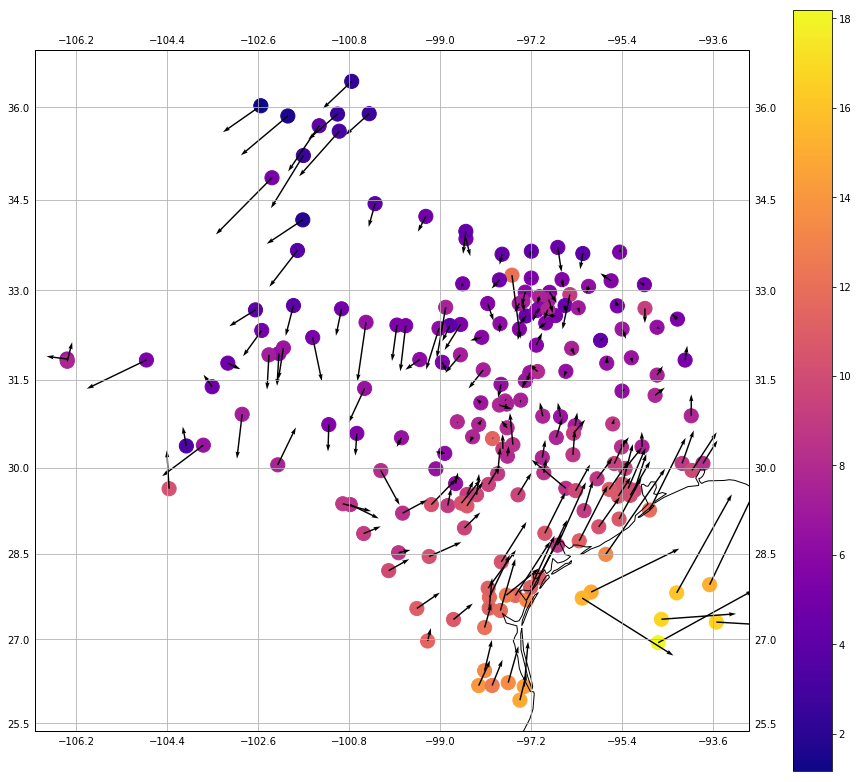

In [4]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=ccrs.Mercator())
maxabs = vd.maxabs(mean.air_temperature_c)
tmp = ax.scatter(mean.longitude, mean.latitude, c=mean.air_temperature_c, s=200, cmap="plasma", transform=crs)
plt.colorbar(tmp)
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.002, transform=crs)
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)

In [10]:
projection = pyproj.Proj(proj="merc", lat_ts=mean.latitude.mean())
proj_coords = projection(mean.longitude.values, mean.latitude.values)
region = vd.get_region((mean.longitude, mean.latitude))
fit_data = (mean.wind_speed_east_knots, mean.wind_speed_north_knots)

In [11]:
vecgrd = vd.Chain([
    ("trend", vd.Components([vd.Trend(degree=1) for i in range(2)])),
    ('spline', vd.Vector2D(poisson=0.5, damping=1e-10, fudge=500e3))
])
print(np.mean(vd.cross_val_score(vecgrd, proj_coords, fit_data)))
vecgrd.fit(proj_coords, fit_data)

0.6830245145754869


Chain(steps=[('trend', Components(components=[Trend(degree=1), Trend(degree=1)])), ('spline', Vector2D(damping=1e-10, fudge=500000.0, poisson=0.5, region=None, shape=None,
     spacing=None))])

In [13]:
vecgrd2 = vd.Chain([
    ("trend", vd.Components([vd.Trend(degree=1) for i in range(2)])),
    ('spline', vd.Components([vd.Spline(damping=1e-15, fudge=500e3) for i in range(2)]))
    #('spline', vd.Components([vd.ScipyGridder() for i in range(2)]))
])
print(np.mean(vd.cross_val_score(vecgrd2, proj_coords, fit_data)))
vecgrd2.fit(proj_coords, fit_data)

0.6843618966009481


Chain(steps=[('trend', Components(components=[Trend(degree=1), Trend(degree=1)])), ('spline', Components(components=[Spline(damping=1e-15, fudge=500000.0, region=None, shape=None, spacing=None), Spline(damping=1e-15, fudge=500000.0, region=None, shape=None, spacing=None)]))])

In [29]:
spacing = 0.3
mask = vd.distance_mask((mean.longitude, mean.latitude), maxdist=1, spacing=spacing, region=region)
grid = vecgrd.grid(spacing=spacing, region=region, projection=projection).where(mask)
grid2 = vecgrd2.grid(spacing=spacing, region=region, projection=projection).where(mask)
diff = grid - grid2
grid

<xarray.Dataset>
Dimensions:          (easting: 44, northing: 36)
Coordinates:
  * easting          (easting) float64 -106.4 -106.1 -105.8 -105.5 -105.2 ...
  * northing         (northing) float64 25.91 26.21 26.51 26.81 27.11 27.41 ...
Data variables:
    east_component   (northing, easting) float64 nan nan nan nan nan nan nan ...
    north_component  (northing, easting) float64 nan nan nan nan nan nan nan ...
Attributes:
    metadata:  Generated by Chain(steps=[('trend', Components(components=[Tre...

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


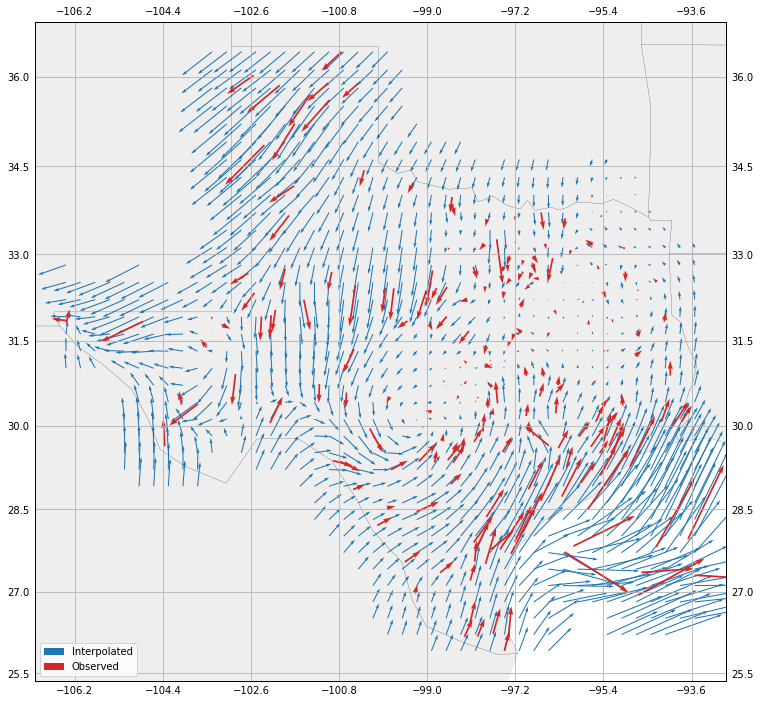

In [30]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 70
ax.quiver(grid.easting.values, grid.northing.values, grid.east_component.values, grid.north_component.values, 
          width=0.0015, transform=crs, scale=scale, color='tab:blue', label="Interpolated")
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.0025, transform=crs, color="tab:red", scale=scale, label="Observed")
ax.gridlines(draw_labels=True)
ax.legend(loc="lower left")
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
ax.add_feature(cfeature.STATES, linewidth=0.1)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
#ax.add_feature(cfeature.OCEAN, facecolor="xkcd:sky blue")
plt.tight_layout()

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


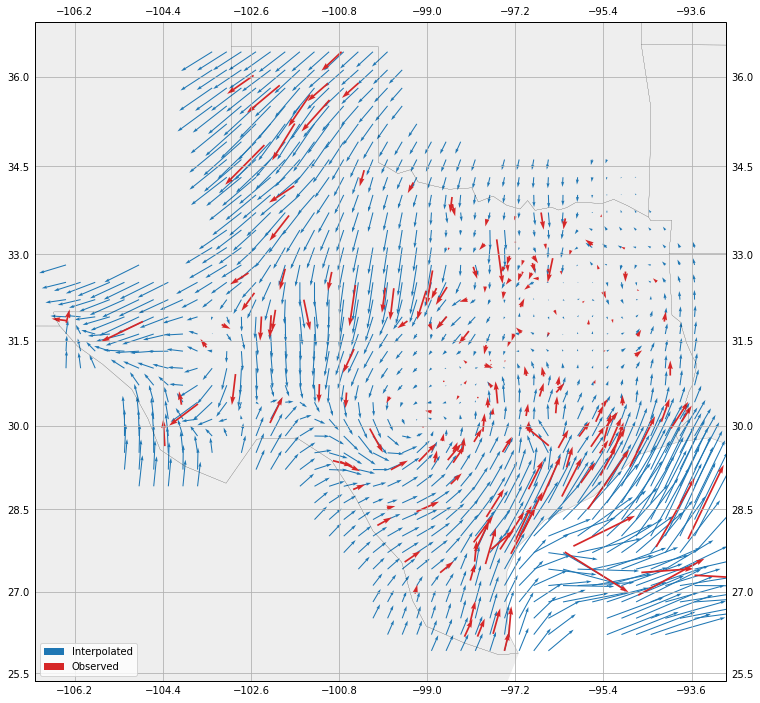

In [31]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 70
ax.quiver(grid2.easting.values, grid2.northing.values, grid2.east_component.values, grid2.north_component.values, 
          width=0.0015, transform=crs, scale=scale, color='tab:blue', label="Interpolated")
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.0025, transform=crs, color="tab:red", scale=scale, label="Observed")
ax.gridlines(draw_labels=True)
ax.legend(loc="lower left")
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
ax.add_feature(cfeature.STATES, linewidth=0.1)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
#ax.add_feature(cfeature.OCEAN, facecolor="xkcd:sky blue")
plt.tight_layout()

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


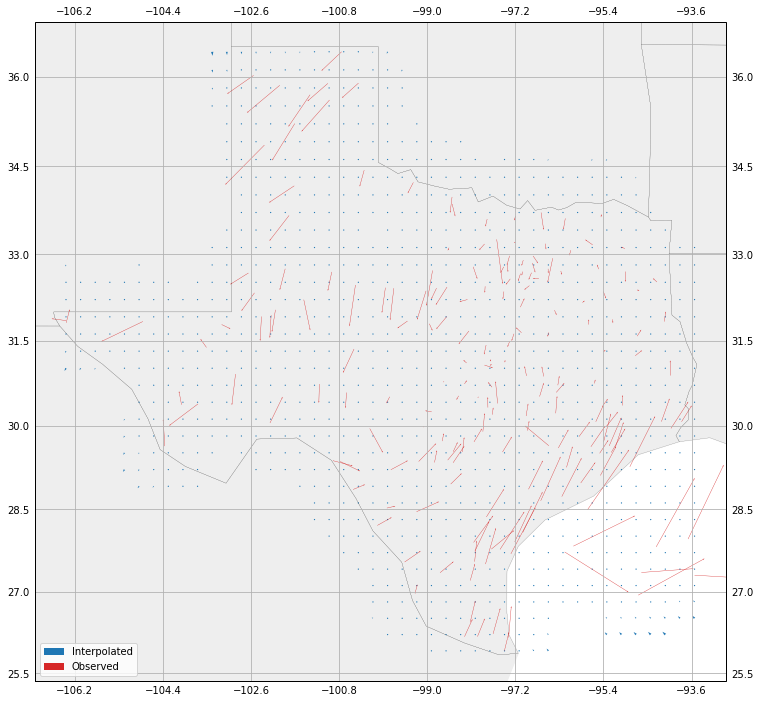

In [32]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 70
ax.quiver(diff.easting.values, diff.northing.values, diff.east_component.values, diff.north_component.values, 
          width=0.002, transform=crs, scale=scale, color='tab:blue', label="Interpolated")
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.0005, transform=crs, color="tab:red", scale=scale, label="Observed")
ax.gridlines(draw_labels=True)
ax.legend(loc="lower left")
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
ax.add_feature(cfeature.STATES, linewidth=0.1)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
#ax.add_feature(cfeature.OCEAN, facecolor="xkcd:sky blue")
plt.tight_layout()